In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="multiprocessing.resource_tracker")

import numpy as np
import matplotlib.pyplot as plt

import nbi

In [2]:
print(nbi.__version__)

0.3.1


As a very simple demostrateion, let us consider a very simple sine curve model, where t is time, f is frequency, A is amplitude, and $\phi_0$ is initial phase:

$f(t) = A\cdot\sin(f\cdot t+\phi_0$)

In [3]:
t = np.linspace(0,1,50)
def sine(param):
    phi0, A, freq = param
    return np.sin(t * freq + phi0) * A

In [4]:
# define prior space of interest

from scipy.stats import uniform, truncnorm
prior = {
    'phi0': uniform(loc=0, scale=np.pi*2),
    'A': uniform(loc=1, scale=4),
    'freq': uniform(loc=2*np.pi, scale=10*np.pi)
}
labels = list(prior.keys())
priors = [prior[k] for k in labels]

# Inference on one dataset (SNPE)

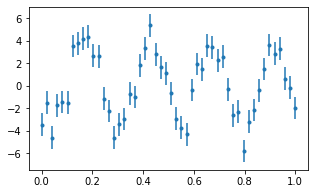

In [35]:
plt.figure(figsize=(5,3))

np.random.seed(0)

# draw random parameter from prior
y_true = [var.rvs(1)[0] for var in priors]

# add fixed gaussian noise of 0.5
x_err = 1
x_obs = sine(y_true) + np.random.normal(size=50) * x_err
plt.errorbar(t, x_obs, yerr=x_err, fmt='.')

plt.show()

In [42]:
# hyperparameters for the normalizing flow
flow_config = {
    'n_dims': 3,
    'flow_hidden': 32,
    'num_cond_inputs': 32,
    'num_blocks': 4
}

# the NBI package provides predefined featurizer NNs for certain types of data
# including 1D sequences
featurizer_config = {
    'type': 'resnet-gru',
    'dim_in': 1,
    'dim_conv_max': 256,
    'depth': 3
}

# initialize NBI engine
engine = nbi.NBI(
    flow=flow_config,
    featurizer=featurizer_config,
    simulator=sine,
    priors=priors,
    labels=labels,
    n_jobs=10
)


---------------------- Round: 1 ----------------------


- Val, Loglike in nats: -0.823580:  98%|█████████▊| 384/391 [00:00<00:00, 1380.17it/s]


Samples outside prior N = 38
Generating simulations


509it [00:00, 988.94it/s]


Effective sample size for current/all rounds 156.8/187.1


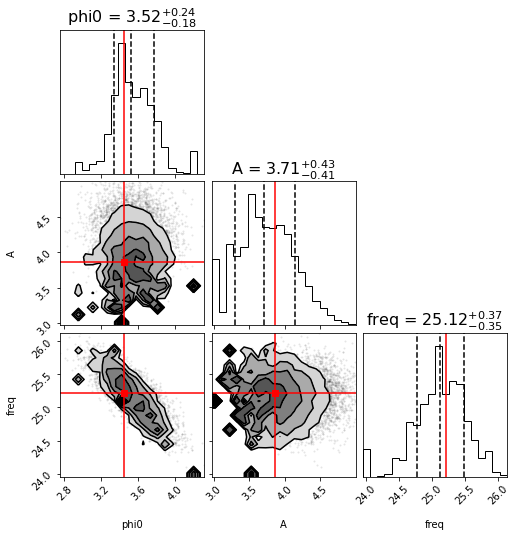

reweighted posterior from all rounds


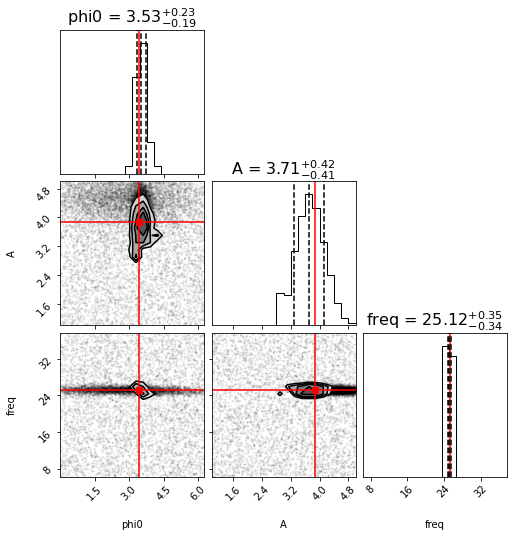

In [44]:
engine.fit(
    x_obs=x_obs,
    y_true=y_true,
    n_sims=5120,
    n_rounds=1,
    n_epochs=10,
    noise=np.array([2]*50)
)

We could generate more posterior samples using the trained NDE

Samples outside prior N = 17
surrogate posterior


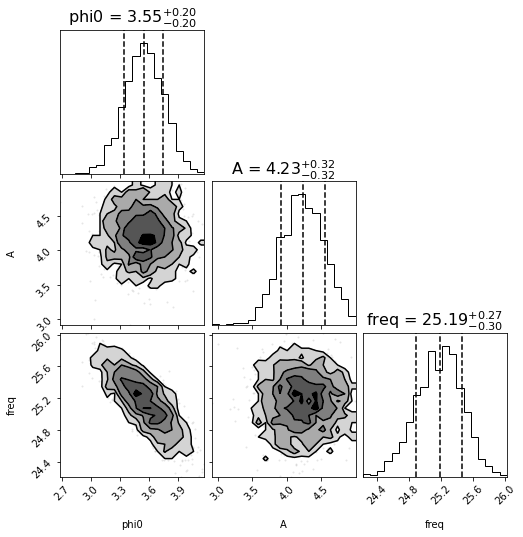

Generating simulations


199it [00:00, 1122.30it/s]


Effective Sample Size = 31.0
Sampling efficiency = 1.6%


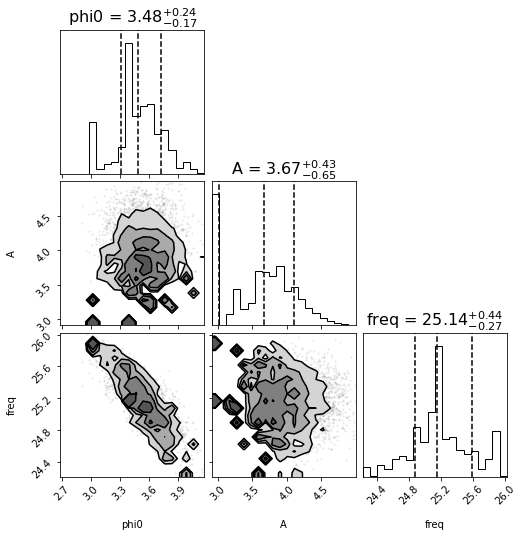

In [45]:
y_pred, weights = engine.predict(x_obs, x_err=np.array([2]*50), n_samples=2000, corner=True, corner_reweight=True)

# Inference on multiple datasets (ANPE)
if we care about a large number of different x_obs, then train nbi for only 1 round on more samples generated from the prior space of interest

In [46]:
# let's say we have a large set of observed sine curves with different noise levels
# instead of initializing the NBI engine with fixed noise, we have provide it with a
# noise function that takes in noise free "x" and returns a noisified x

def noise(x, y):
    rand = np.random.normal(0, 1, size=x.shape[0])
    
    # let's say x_err is drawn from [0.5, 2.5]
    x_err = np.random.uniform() * 2 + 0.5
    x_noise = x + rand * x_err
    return x_noise, y

In [59]:
# hyperparameters for the normalizing flow
flow_config = {
    'n_dims': 3,
    'flow_hidden': 32,
    'num_cond_inputs': 32,
    'num_blocks': 4
}

# the NBI package provides predefined featurizer NNs for certain types of data
# including 1D sequences
featurizer_config = {
    'type': 'resnet-gru',
    'dim_in': 1,
    'dim_conv_max': 256,
    'depth': 3
}


# initialize NBI engine
engine = nbi.NBI(
    flow=flow_config,
    featurizer=featurizer_config,
    simulator=sine,
    priors=priors,
    labels=labels,
    n_jobs=10
)

In [60]:
engine.fit(
    n_sims=5120 * 2,
    n_rounds=1,
    n_epochs=5,
    noise=noise
)

Generating simulations


1024it [00:01, 713.32it/s]



---------------------- Round: 0 ----------------------


- Val, Loglike in nats: 0.753307: 100%|██████████| 1024/1024 [00:00<00:00, 1510.81it/s]


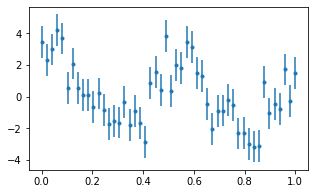

In [61]:
# to do inference with the trained engine, input x_obs and desired effective sample size of the posterior sample

x_err = 1
np.random.seed(0)

y_true = [1, 2, 4*np.pi]
x_obs = sine(y_true) + np.random.normal(size=50) * x_err

plt.figure(figsize=(5,3))
plt.errorbar(t, x_obs, yerr=x_err, fmt='.')
plt.show()

Samples outside prior N = 50
Generating simulations


495it [00:00, 933.82it/s]


Effective Sample Size = 759.0
Sampling efficiency = 15.2%


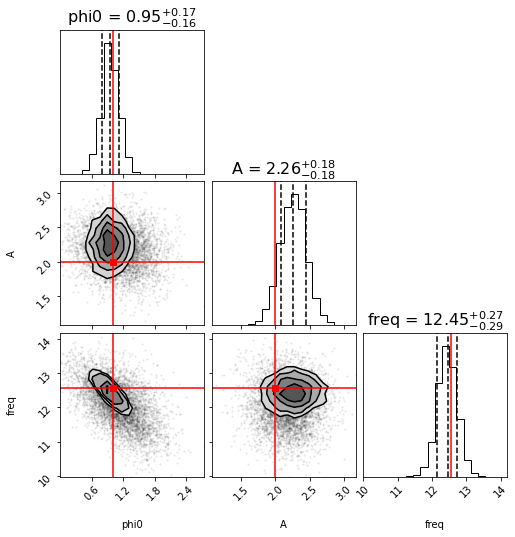

In [65]:
# the first corner plot is the nbi surrogate posterior
# the second corner plot is the importance reweighted posterior
ys, weights = engine.predict(x_obs, x_err=np.array([1]), n_samples=5000, y_true=y_true, corner_reweight=True)

<ErrorbarContainer object of 3 artists>

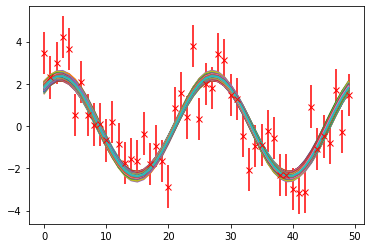

In [67]:
# posterior predictive checks
# select top 100 best fitting parameters
ind = np.argsort(weights)
xs = np.array([sine(ys[i]) for i in ind[-100:]])
plt.plot(xs.T)
plt.errorbar(range(50), x_obs, yerr=1, fmt='rx')